### Preparation

In [93]:
import tqdm
import os
import cv2
import imghdr
import image_to_numpy
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import datetime

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomContrast, RandomBrightness, Rescaling, Resizing
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, ReLU
from tensorflow.keras.metrics import F1Score, Precision, Recall, CategoricalAccuracy

from sklearn.metrics import classification_report,confusion_matrix

In [2]:
data_dir = 'D:\DATASETS\For-Thesis\Labels'

In [3]:
def sample_count(data_dir):
    for dir in os.listdir(data_dir):
        print("{}: {}".format(dir, len(os.listdir(os.path.join(data_dir,dir)))))

In [4]:
sample_count(data_dir)

Building: 400
Plant: 400
Road: 400
Vehicle: 400


### Prepare Dataset

In [14]:
labels = ['Building', 'Plant', 'Road', 'Vehicle']
X_train = []
y_train = []
y_label_idx = []
image_size = 256
for i in labels:
    folderPath = os.path.join('D:\DATASETS\For-Thesis\Labels', i)
    for j in os.listdir(folderPath):
        img = image_to_numpy.load_image_file(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_label_idx.append(labels.index(i))

In [48]:
X_train = np.array(X_train)
y_label_idx = np.array(y_label_idx)

X_train_scaled = X_train.astype(np.float32) / 255.0
y_one_hot = tf.keras.utils.to_categorical(y_label_idx)

In [49]:
y_one_hot[0]

array([1., 0., 0., 0.], dtype=float32)

In [56]:
dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_one_hot))
dataset = dataset.shuffle(buffer_size=dataset.cardinality(), seed=1).batch(8)

In [57]:
dataset_iter = dataset.as_numpy_iterator()

In [64]:
batch = dataset_iter.next()

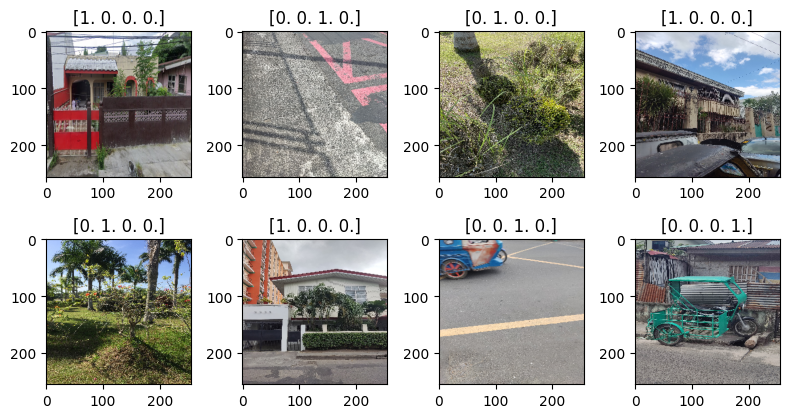

In [66]:
fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(8,4.5))
for i in range(4):
    ax[0][i].imshow(batch[0][i].astype(float))
    ax[0][i].title.set_text(batch[1][i])
    
for i in range(4,8):
    ax[1][i - 4].imshow(batch[0][i].astype(float))
    ax[1][i - 4].title.set_text(batch[1][i])
    
fig.tight_layout()
plt.subplots_adjust(hspace=0.1)
plt.show()

In [67]:
total_batch_count = len(dataset) 
train_batch_count = total_batch_count // 4 * 3  # 75% of batches
test_batch_count = total_batch_count - train_batch_count
print(total_batch_count , train_batch_count, test_batch_count)

200 150 50


In [68]:
train_size, test_size = train_batch_count, test_batch_count
train_set = dataset.take(train_size)
test_set = dataset.skip(train_size).take(test_size)

In [70]:
train_set, val_set = tf.keras.utils.split_dataset(dataset=train_set, left_size=0.75, shuffle=True, seed=1)

### Make Model

In [73]:
model = Sequential()
model.add(RandomFlip(mode='horizontal', seed=1, input_shape=(256,256,3)))
model.add(RandomRotation(factor=0.2, seed=1))

model.add(Conv2D(input_shape=(256,256,3), filters=16, kernel_size=(3,3), padding="same"))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D())

model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same"))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D())

model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same"))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(units=128,activation="relu"))
model.add(Dense(units=64,activation="relu"))

model.add(Dense(units=4, activation="softmax"))
model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [74]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 random_rotation_1 (RandomR  (None, 256, 256, 3)       0         
 otation)                                                        
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 batch_normalization_3 (Bat  (None, 256, 256, 16)      64        
 chNormalization)                                                
                                                                 
 re_lu_3 (ReLU)              (None, 256, 256, 16)      0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 128, 128, 16)     

In [75]:
file_name = 'Model_V4-0-0_' + datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = f'./logs/{file_name}'
checkpoint_filepath = f'./checkpoints/{file_name}'

tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                             histogram_freq=1,
                                             profile_batch=2,
                                             write_graph=True,
                                             write_images=True,
                                            )
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                               patience=5)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, 
                                                         monitor='val_accuracy', 
                                                         mode='auto', 
                                                         save_best_only=True, 
                                                         verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                 factor=0.3, 
                                                 patience=2, 
                                                 min_delta=0.001, 
                                                 mode='auto', 
                                                 verbose=1)

### Train and Inspect Model

In [76]:
hist = model.fit(train_set, 
                 validation_data=val_set, 
                 epochs=10,
                 verbose=1,
                 callbacks=[tb_callback, es_callback, cp_callback, reduce_lr])

Epoch 1/10


112/112 [==============================] - ETA: 0s - loss: 2.6853 - accuracy: 0.5190
Epoch 1: val_accuracy improved from -inf to 0.26316, saving model to ./checkpoints\Model_V4-0-0
INFO:tensorflow:Assets written to: ./checkpoints\Model_V4-0-0\assets


INFO:tensorflow:Assets written to: ./checkpoints\Model_V4-0-0\assets


112/112 [==============================] - 34s 262ms/step - loss: 2.6853 - accuracy: 0.5190 - val_loss: 6.4679 - val_accuracy: 0.2632 - lr: 0.0010
Epoch 2/10
112/112 [==============================] - ETA: 0s - loss: 1.0679 - accuracy: 0.6853
Epoch 2: val_accuracy improved from 0.26316 to 0.42105, saving model to ./checkpoints\Model_V4-0-0
INFO:tensorflow:Assets written to: ./checkpoints\Model_V4-0-0\assets


INFO:tensorflow:Assets written to: ./checkpoints\Model_V4-0-0\assets


112/112 [==============================] - 27s 246ms/step - loss: 1.0679 - accuracy: 0.6853 - val_loss: 3.6952 - val_accuracy: 0.4211 - lr: 0.0010
Epoch 3/10
112/112 [==============================] - ETA: 0s - loss: 0.7949 - accuracy: 0.7176
Epoch 3: val_accuracy did not improve from 0.42105
112/112 [==============================] - 23s 204ms/step - loss: 0.7949 - accuracy: 0.7176 - val_loss: 1.7386 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 4/10
112/112 [==============================] - ETA: 0s - loss: 0.6739 - accuracy: 0.7377
Epoch 4: val_accuracy improved from 0.42105 to 0.75658, saving model to ./checkpoints\Model_V4-0-0
INFO:tensorflow:Assets written to: ./checkpoints\Model_V4-0-0\assets


INFO:tensorflow:Assets written to: ./checkpoints\Model_V4-0-0\assets


112/112 [==============================] - 28s 251ms/step - loss: 0.6739 - accuracy: 0.7377 - val_loss: 0.7278 - val_accuracy: 0.7566 - lr: 0.0010
Epoch 5/10
112/112 [==============================] - ETA: 0s - loss: 0.6158 - accuracy: 0.7723
Epoch 5: val_accuracy improved from 0.75658 to 0.81579, saving model to ./checkpoints\Model_V4-0-0
INFO:tensorflow:Assets written to: ./checkpoints\Model_V4-0-0\assets


INFO:tensorflow:Assets written to: ./checkpoints\Model_V4-0-0\assets


112/112 [==============================] - 28s 248ms/step - loss: 0.6158 - accuracy: 0.7723 - val_loss: 0.4884 - val_accuracy: 0.8158 - lr: 0.0010
Epoch 6/10
112/112 [==============================] - ETA: 0s - loss: 0.5921 - accuracy: 0.7712
Epoch 6: val_accuracy did not improve from 0.81579
112/112 [==============================] - 24s 213ms/step - loss: 0.5921 - accuracy: 0.7712 - val_loss: 1.5683 - val_accuracy: 0.4211 - lr: 0.0010
Epoch 7/10
112/112 [==============================] - ETA: 0s - loss: 0.5566 - accuracy: 0.7690
Epoch 7: val_accuracy did not improve from 0.81579

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
112/112 [==============================] - 23s 206ms/step - loss: 0.5566 - accuracy: 0.7690 - val_loss: 0.6355 - val_accuracy: 0.7303 - lr: 0.0010
Epoch 8/10
112/112 [==============================] - ETA: 0s - loss: 0.3509 - accuracy: 0.8638
Epoch 8: val_accuracy improved from 0.81579 to 0.86184, saving model to ./checkpoints\Model_

INFO:tensorflow:Assets written to: ./checkpoints\Model_V4-0-0\assets


112/112 [==============================] - 28s 250ms/step - loss: 0.3509 - accuracy: 0.8638 - val_loss: 0.3824 - val_accuracy: 0.8618 - lr: 3.0000e-04
Epoch 9/10
112/112 [==============================] - ETA: 0s - loss: 0.3031 - accuracy: 0.8750
Epoch 9: val_accuracy improved from 0.86184 to 0.87829, saving model to ./checkpoints\Model_V4-0-0
INFO:tensorflow:Assets written to: ./checkpoints\Model_V4-0-0\assets


INFO:tensorflow:Assets written to: ./checkpoints\Model_V4-0-0\assets


112/112 [==============================] - 28s 249ms/step - loss: 0.3031 - accuracy: 0.8750 - val_loss: 0.3440 - val_accuracy: 0.8783 - lr: 3.0000e-04
Epoch 10/10
112/112 [==============================] - ETA: 0s - loss: 0.2878 - accuracy: 0.8795
Epoch 10: val_accuracy did not improve from 0.87829
112/112 [==============================] - 23s 207ms/step - loss: 0.2878 - accuracy: 0.8795 - val_loss: 0.5304 - val_accuracy: 0.7993 - lr: 3.0000e-04


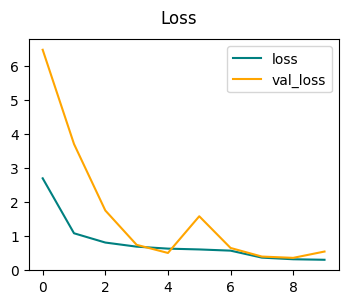

In [77]:
fig = plt.figure(figsize=(4,3))
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
plt.suptitle('Loss')
plt.legend(loc='upper right')
plt.show()

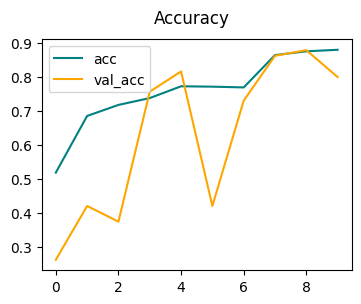

In [78]:
fig = plt.figure(figsize=(4,3))
plt.plot(hist.history['accuracy'], color='teal', label='acc')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_acc')
plt.suptitle('Accuracy')
plt.legend(loc='upper left')
plt.show()

### Evaluate Model

In [84]:
f1 = F1Score()
pre = Precision()
rec = Recall()
c_acc = CategoricalAccuracy()

In [85]:
for batch in test_set.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    f1.update_state(y, yhat)
    pre.update_state(y, yhat)
    rec.update_state(y, yhat)
    c_acc.update_state(y, yhat)

1/1 [==============================] - 0s 78ms/step


In [86]:
def print_scores(f1, pre, rec, c_acc):
    f1_score = f1.result().numpy() * 100
    pre_score = pre.result().numpy() * 100
    rec_score = rec.result().numpy() * 100
    c_acc_score = c_acc.result().numpy() * 100
    print(f"Precision: {pre_score:.2f}")
    print(f"Recall: {rec_score:.2f}")
    print(f"Categorical Accuracy: {c_acc_score:.2f}")
    print("F1 Score: ", f1_score)

In [87]:
print_scores(f1, pre, rec, c_acc)

Precision: 83.03
Recall: 79.50
Categorical Accuracy: 81.75
F1 Score:  [65.47619 79.69349 95.14563 84.84848]


In [90]:
# Same as evaluating through the CatgeoricalAccuracy()

test_result = model.evaluate(test_set, return_dict=True, verbose=2)
print(test_result)

50/50 - 2s - loss: 0.4950 - accuracy: 0.8300 - 2s/epoch - 39ms/step
{'loss': 0.4949512183666229, 'accuracy': 0.8299999833106995}


### More Visualization

In [91]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

import datetime

In [92]:
# AppData/Local/Temp/.tensorboard-info - delete folder if it cannot load
%tensorboard --logdir=logs/

## Load Model from Checkpoint and Evaluate

In [96]:
saved_model = tf.keras.models.load_model('checkpoints\\Model_V4-0-0')

In [97]:
saved_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 random_rotation_1 (RandomR  (None, 256, 256, 3)       0         
 otation)                                                        
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 batch_normalization_3 (Bat  (None, 256, 256, 16)      64        
 chNormalization)                                                
                                                                 
 re_lu_3 (ReLU)              (None, 256, 256, 16)      0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 128, 128, 16)     

In [105]:
best_result = saved_model.evaluate(test_set, return_dict=True, verbose=2)
print(best_result)

50/50 - 2s - loss: 0.2727 - accuracy: 0.8900 - 2s/epoch - 39ms/step
{'loss': 0.27270492911338806, 'accuracy': 0.8899999856948853}


In [101]:
f1 = F1Score()
pre = Precision()
rec = Recall()
c_acc = CategoricalAccuracy()

In [102]:
for batch in test_set.as_numpy_iterator():
    X, y = batch
    yhat = saved_model.predict(X)
    f1.update_state(y, yhat)
    pre.update_state(y, yhat)
    rec.update_state(y, yhat)
    c_acc.update_state(y, yhat)

1/1 [==============================] - 0s 104ms/step


In [103]:
print_scores(f1, pre, rec, c_acc)

Precision: 90.00
Recall: 87.75
Categorical Accuracy: 89.00
F1 Score:  [83.      94.49541 96.51741 80.66299]
